<a href="https://colab.research.google.com/github/ShwethaSureshKumar/Image-tampering-detection/blob/main/Image_tampering_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from joblib import dump
import joblib
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
def preprocess_image(image):
    # Ensure the image is in the correct data type (CV_8U)
    if image.dtype != 'uint8':
        image = cv2.convertScaleAbs(image)

    # Perform other preprocessing steps as needed (e.g., resizing, normalization)

    return image

def predict_image_tampering(image_features, svm_model):
    # Make a prediction using the loaded SVM classifier
    prediction = svm_model.predict([image_features])

    # Determine the class based on predictions (e.g., 0 for Authentic, 1 for Tampered)
    result = "Authentic" if prediction == 0 else "Tampered"

    return result

def extract_image_features(image):
    hist_hue, hist_saturation, hist_value = extract_color_histograms(image)
    lbp_histogram = extract_lbp_histogram(image)
    sharpness = calculate_laplacian_variance(image)
    brightness = calculate_brightness(image)
    blur_score = calculate_blur(image)

    # Flatten the histograms and LBP histogram into 1D arrays
    hist_hue_flat = hist_hue.flatten()
    hist_saturation_flat = hist_saturation.flatten()
    hist_value_flat = hist_value.flatten()
    lbp_histogram_flat = lbp_histogram.flatten()

    # Concatenate the flattened arrays along with sharpness, brightness, and blur_score
    image_fet = np.concatenate([hist_hue_flat, hist_saturation_flat, hist_value_flat, lbp_histogram_flat, [sharpness, brightness, blur_score]])

    return image_fet

def extract_color_histograms(image):
    # Convert the image to the desired color space (e.g., HSV)
    image=preprocess_image(image)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate histograms for each channel
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])

    return hist_hue, hist_saturation, hist_value


def extract_lbp_histogram(image):
    image=preprocess_image(image)
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate LBP features
    lbp = feature.local_binary_pattern(gray_image, P=8, R=1, method="uniform")

    # Calculate the histogram of LBP
    hist = cv2.calcHist([lbp.astype("uint8")], [0], None, [256], [0, 256])

    return hist


def calculate_laplacian_variance(image):
    image=preprocess_image(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
    laplacian_var = laplacian.var()
    return laplacian_var

def calculate_brightness(image):
    image=preprocess_image(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray_image)
    return brightness

def calculate_blur(image):
    image=preprocess_image(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
    blur_score = laplacian.var()
    return blur_score


def load_and_preprocess_dataset(dataset_dir, image_size=(128, 128)):
    authentic_path = os.path.join(dataset_dir, "ORIGINAL")
    tampered_path = os.path.join(dataset_dir, "TAMPERED")

    authentic_images = []
    tampered_images = []
    labels = []  # 0 for authentic, 1 for tampered

    # Load and preprocess authentic images
    for image_file in os.listdir(authentic_path):
        if image_file.endswith(".jpg") or image_file.endswith(".png"):
            image_path = os.path.join(authentic_path, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                # Resize the image to the specified size
                image = cv2.resize(image, image_size)
                # Normalize pixel values to [0, 1]
                image = image / 255.0
                authentic_images.append(image)
                labels.append(0)  # Authentic

    # Load and preprocess tampered images
    for image_file in os.listdir(tampered_path):
        if image_file.endswith(".jpg") or image_file.endswith(".png"):
            image_path = os.path.join(tampered_path, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                # Resize the image to the specified size
                image = cv2.resize(image, image_size)
                # Normalize pixel values to [0, 1]
                image = image / 255.0
                tampered_images.append(image)
                labels.append(1)  # Tampered

    # Convert the lists to NumPy arrays
    authentic_images = np.array(authentic_images)
    tampered_images = np.array(tampered_images)
    labels = np.array(labels)

    return authentic_images, tampered_images, labels

In [4]:
# Example usage
dataset_dir = "/content/drive/MyDrive/image tampering detection"
authentic_images, tampered_images, labels = load_and_preprocess_dataset(dataset_dir)

# Check the shapes and labels
print("Authentic Images Shape:", authentic_images.shape)
print("Tampered Images Shape:", tampered_images.shape)
print("Labels Shape:", labels.shape[0])


Authentic Images Shape: (730, 128, 128, 3)
Tampered Images Shape: (730, 128, 128, 3)
Labels Shape: 1460


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Create empty lists to store feature vectors and labels
authentic_features = []
tampered_features = []
labels = []

# Iterate through authentic images and extract features
for auth_image in authentic_images:
    hist_hue, hist_saturation, hist_value = extract_color_histograms(auth_image)
    lbp_histogram = extract_lbp_histogram(auth_image)
    sharpness = calculate_laplacian_variance(auth_image)
    brightness = calculate_brightness(auth_image)
    blur_score = calculate_blur(auth_image)

    # Flatten the histograms and LBP histogram into 1D arrays
    hist_hue_flat = hist_hue.flatten()
    hist_saturation_flat = hist_saturation.flatten()
    hist_value_flat = hist_value.flatten()
    lbp_histogram_flat = lbp_histogram.flatten()

    # Concatenate the flattened arrays along with sharpness, brightness, and blur_score
    auth_feature_vector = np.concatenate([hist_hue_flat, hist_saturation_flat, hist_value_flat, lbp_histogram_flat, [sharpness, brightness, blur_score]])

    authentic_features.append(auth_feature_vector)
    labels.append(0)  # Authentic

# Iterate through tampered images and extract features
for tampered_image in tampered_images:
    hist_hue, hist_saturation, hist_value = extract_color_histograms(tampered_image)
    lbp_histogram = extract_lbp_histogram(tampered_image)
    sharpness = calculate_laplacian_variance(tampered_image)
    brightness = calculate_brightness(tampered_image)
    blur_score = calculate_blur(tampered_image)

    # Flatten the histograms and LBP histogram into 1D arrays
    hist_hue_flat = hist_hue.flatten()
    hist_saturation_flat = hist_saturation.flatten()
    hist_value_flat = hist_value.flatten()
    lbp_histogram_flat = lbp_histogram.flatten()

    # Concatenate the flattened arrays along with sharpness, brightness, and blur_score
    tampered_feature_vector = np.concatenate([hist_hue_flat, hist_saturation_flat, hist_value_flat, lbp_histogram_flat, [sharpness, brightness, blur_score]])

    tampered_features.append(tampered_feature_vector)
    labels.append(1)  # Tampered

# Convert the lists to NumPy arrays
authentic_features = np.array(authentic_features)
tampered_features = np.array(tampered_features)
labels = np.array(labels)

print("Authentic Feature:", authentic_features)
print("Tampered Feature:", tampered_features)
print("Labels Shape:", labels)

all_features = np.concatenate((authentic_features, tampered_features), axis=0)

Authentic Feature: [[1.61110000e+04 0.00000000e+00 0.00000000e+00 ... 2.66357407e-01
  8.51928711e-01 2.66357407e-01]
 [1.56290000e+04 0.00000000e+00 0.00000000e+00 ... 1.82983398e-01
  3.27026367e-01 1.82983398e-01]
 [5.01100000e+03 0.00000000e+00 0.00000000e+00 ... 2.15758201e-01
  7.36083984e-01 2.15758201e-01]
 ...
 [1.63840000e+04 0.00000000e+00 0.00000000e+00 ... 7.42058218e-01
  6.13342285e-01 7.42058218e-01]
 [1.63840000e+04 0.00000000e+00 0.00000000e+00 ... 2.93334961e-01
  7.46459961e-02 2.93334961e-01]
 [1.63840000e+04 0.00000000e+00 0.00000000e+00 ... 2.29247987e-01
  2.30651855e-01 2.29247987e-01]]
Tampered Feature: [[1.63840000e+04 0.00000000e+00 0.00000000e+00 ... 1.54721405e-01
  1.70898438e-01 1.54721405e-01]
 [1.63840000e+04 0.00000000e+00 0.00000000e+00 ... 9.61303674e-02
  8.60412598e-01 9.61303674e-02]
 [1.63840000e+04 0.00000000e+00 0.00000000e+00 ... 4.17724475e-01
  5.72326660e-01 4.17724475e-01]
 ...
 [1.63840000e+04 0.00000000e+00 0.00000000e+00 ... 3.64073362

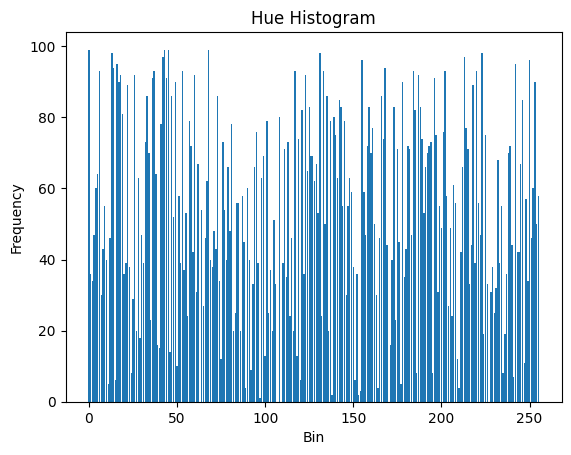

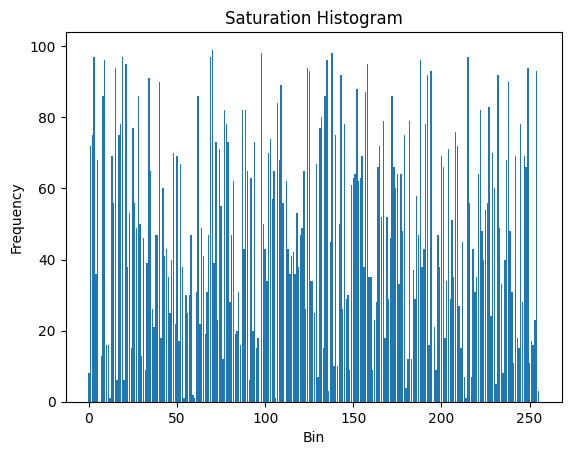

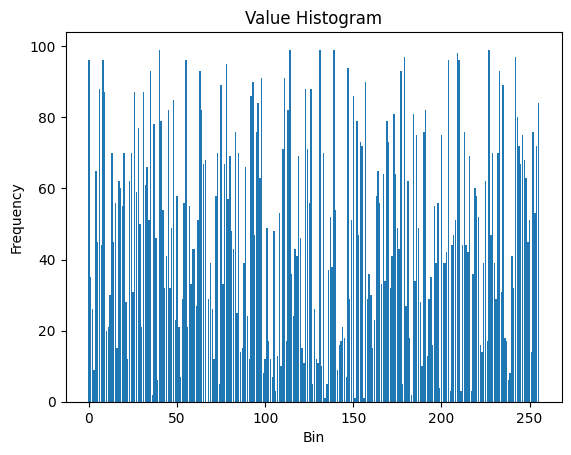

In [ ]:
def plot_histogram(hist, channel_name):
    plt.bar(range(len(hist)), hist)
    plt.title(f'{channel_name} Histogram')
    plt.xlabel('Bin')
    plt.ylabel('Frequency')
    plt.show()


# Plot the histograms
plot_histogram(hist_hue, 'Hue')
plot_histogram(hist_saturation, 'Saturation')
plot_histogram(hist_value, 'Value')


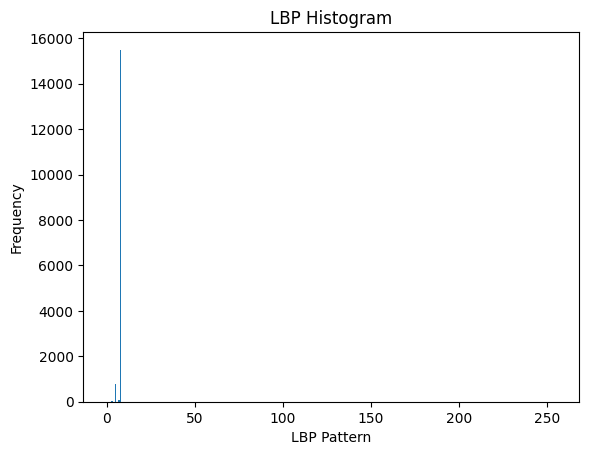

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Create an array of bin indices (0, 1, 2, ...)
bin_indices = np.arange(len(lbp_histogram))

# Create a bar chart to visualize the LBP histogram
plt.bar(bin_indices, lbp_histogram)
plt.title('LBP Histogram')
plt.xlabel('LBP Pattern')
plt.ylabel('Frequency')
plt.show()


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svm_classifier.predict(X_test)

Accuracy: 60.62%
Precision: 58.90%
Recall: 66.67%
F1 Score: 62.54%
Confusion Matrix:
[[81 67]
 [48 96]]


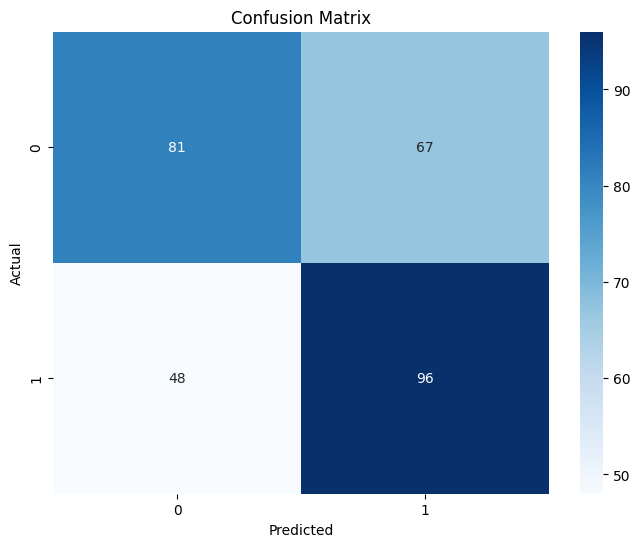

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model_filename = 'svm_model.pkl'
dump(svm_classifier, model_filename)
print(f"SVM model saved to {model_filename}")


# Load the pre-trained SVM model
svm_classifier = joblib.load('svm_model.pkl')

# Load and preprocess the testing image
image_path = "/content/drive/MyDrive/image tampering detection/TAMPERED/Im2_col4.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (128,128))
image = image / 255.0

image_features = extract_image_features(image)

# Make a prediction using the loaded SVM classifier
result = predict_image_tampering(image_features, svm_classifier)

# Display the results
print(f"Image Prediction: {result}")

NameError: ignored